In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import csv
import PIL

import os

# First Pass on the Sample Dataset

To do:
- labeling and train/test split
- creation of the top20 and the 'all' dataset
- first training loop and finetuning on small dataset
- dealing with imbalanced classes (weighing, focal loss)

We will refactor out everything in a module after this exploratory phase to run on the hi-def dataset

## Dataset Pre-processing


First let's load the annotations file:

In [2]:
## commas in last column so let's quote it:
def fix_quotes(in_csv, out_csv):
    """
    fixes the problem with commas in last column of csv by quoting last column of csv
    in_csv: string path to the raw csv file
    out_csv: string path to the desired output file.
        Will be created if not already existing. If already existing, file will be overwritten
    """
    with open(in_csv) as f, open(out_csv, 'w+') as o:
        reader, writer = csv.reader(f), csv.writer(o)
        for line in reader:
            newline = line[:9] + [','.join(line[9:])]
            writer.writerow(newline)

In [3]:
fix_quotes('../data/small/styles.csv', '../data/small/styles_quoted.csv')

In [4]:
styles = pd.read_csv('../data/small/styles_quoted.csv')

In [5]:
styles.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


We also need a way to open the images from files:

In [6]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = PIL.Image.open(f)
        return img.convert('RGB')

### How to organize the data/datasets/dataloaders?

In addition to the usual train/test split, we need here to split the data in top20/not top20.
To do that we'll implement a helper class, `FashionData` containing the train and test datasets:

In [7]:
class FashionData:
    def __init__(self, csv_file, images_root, train_transform=None, test_transform=None, top20=False):
        self.images_root = images_root
        self.top20 = top20
        self.csv_file = csv_file
        
        self.imagelist = [imagefile.split('.')[0] for imagefile in os.listdir(images_root)]
        self.label_data = pd.read_csv(csv_file)
        self.filter_existing_images()
        self.make_label_utils()
        if top20: self.filter_top20()
        
        
        self.train_ds = FashionDataset(self.label_data[self.label_data.year % 2 == 0].reset_index(drop=True),
                                      images_root,
                                      train_transform)
        self.test_ds = FashionDataset(self.label_data[self.label_data.year % 2 == 1].reset_index(drop=True),
                                     images_root,
                                     test_transform)
        
    def make_label_utils(self):
        self.idx2name = self.label_data.articleType.value_counts().index.values
        self.name2idx = {name: idx for idx, name in enumerate(self.idx2name)}
            
    def filter_existing_images(self):
        """
        truncates the dataframe to images that are found in path
        """
        self.label_data = self.label_data[self.label_data.id.isin(self.imagelist)]
        if len(self.label_data) == 0: raise FileNotFoundError('Image directory is empty or does not match csv file')
    
    def filter_top20(self):
        self.label_data = self.label_data[self.label_data.articleType.isin(self.idx2name[:20])]

Remains now to implement `FashionDataset` inheriting from the torchdata `Dataset`:

In [8]:
class FashionDataset(torch.utils.data.Dataset):
    def __init__(self, label_data, images_root, transform=None):
        """
        csv_file: path to csv file containing the labels (styles.csv)
        images_root: path to the images
        transform: list of transforms we want to apply
        train: whether we want to get the train images or the test images
        top20: whether we want to limit the images to the top20 most frequent classes
        """
        self.images_root = images_root
        self.transform = transform
        self.label_data = label_data
            
    def __len__(self):
        return len(self.label_data)
    
    def __getitem__(self, idx):
        img_id, label = self.label_data.loc[idx, ['id', 'articleType']].values
        filename = os.path.join(self.images_root, str(img_id) + '.jpg')
        
        img = pil_loader(filename)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label
    
        
        


### Data Augmentation & checking that this all works

We want to implement basic data augmentation. Here I only use a couple torchvision transformations, but it would be interesting to test the impact of adding more transforms (affine transforms, color/hue/saturation).

Also the usual ImageNet normalization.

The resize and crop are a little strange here - just don't want the output image to be too small for Resnet

In [9]:
train_transform = transforms.Compose([
        transforms.Resize(300),
        transforms.RandomCrop(220),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(300),
        transforms.CenterCrop(220),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [10]:
data = FashionData('../data/small/styles_quoted.csv',
                   '../data/small/images/',
                  train_transform=train_transform,
                  test_transform=test_transform,
                  top20=True)

In [11]:
len(data.test_ds), len(data.train_ds)

(15148, 18000)

In [12]:
def tensor2img(tensor):
    """
    converts tensor and displays image
    """
    rescaled = (tensor - tensor.min())/(tensor.max() - tensor.min())
    plt.imshow(rescaled.numpy().swapaxes(0, 2).swapaxes(0, 1))

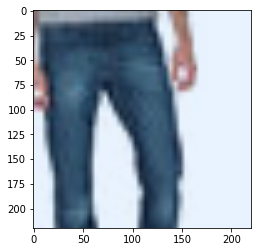

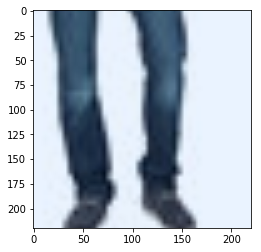

In [13]:
plt.figure()
tensor2img(data.train_ds[0][0])
plt.figure()
tensor2img(data.train_ds[0][0])

Looks like everything works OK. Remains to shove these in the dataloaders:

In [14]:
train_dl = torch.utils.data.DataLoader(data.train_ds,
                                 batch_size=64, shuffle=True,
                                 num_workers=4)
test_dl = torch.utils.data.DataLoader(data.test_ds,
                                 batch_size=128, shuffle=True,
                                 num_workers=4)

In [15]:
n_classes = len(data.idx2name)

## Basic training loop to see if everything works

We first load the pretrained resnet and change the last layer.

In [16]:
model = torchvision.models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features

## replacing the last layer with the dense layer we need
model.fc = nn.Linear(num_ftrs, n_classes)

In [17]:
batch, labels = next(iter(train_dl))

In [18]:
model(batch).shape

torch.Size([64, 142])

Model runs, now let's walk through a basic training loop to see if it trains. We'll factor out the training loop after.

In [19]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.cuda();

In [20]:
n_epochs = 3
for epoch in range(n_epochs):
    print('------------- epoch: ', epoch)
    
    # training
    running_losses = []
    model.train()
    for images, labels in train_dl:
        images = images.cuda()
        labels = torch.tensor([data.name2idx[label] for label in labels]).cuda()
        optimizer.zero_grad()
        out = model(images)

        loss = loss_func(out, labels)
        running_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
    print('Training loss: {:.3f}'.format(np.mean(running_losses)))
        
    # validation
    model.eval()
    running_val_losses = []
    running_accuracies = []
    for images, labels in test_dl:
        with torch.no_grad():
            images = images.cuda()
            labels = torch.tensor([data.name2idx[label] for label in labels]).cuda()
            out = model(images)
            loss = loss_func(out, labels)
            running_val_losses.append(loss.item())
            _, predicted = torch.max(out.data, 1)
            running_accuracies.append((predicted == labels).float().mean().item())
        
    print('Validation loss: {:.3f}'.format(np.mean(running_val_losses)))
    print('Validation accuracy: {:.3f}'.format(np.mean(running_accuracies)))
    
    
    
    
    

------------- epoch:  0
Training loss: 0.762
Validation loss: 1.643
Validation accuracy: 0.655
------------- epoch:  1
Training loss: 0.471
Validation loss: 1.287
Validation accuracy: 0.708
------------- epoch:  2
Training loss: 0.397
Validation loss: 1.060
Validation accuracy: 0.787


____
Model is training, accuracy seems like it's on the right track. Fine tuning on rare classes tomorrow, then moving on to the real dataset.